## Load data

In [27]:
import numpy as np
from keras.utils.np_utils import to_categorical
import keras

In [28]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
datapath = '/media/sf_VBox_Shared/timeseries/PAMAP2_Dataset/slidingwindow512cleaned/'

In [30]:
ext = '.npy'
X_train = np.load(datapath+'X_train'+ext)
y_train_binary = np.load(datapath+'y_train_binary'+ext)
X_val = np.load(datapath+'X_val'+ext)
y_val_binary = np.load(datapath+'y_val_binary'+ext)
X_test = np.load(datapath+'X_test'+ext)
y_test_binary = np.load(datapath+'y_test_binary'+ext)

In [31]:
num_classes = y_train_binary.shape[1]
print(num_classes)

12


## Generate models

In [32]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Convolution1D, Flatten, MaxPooling1D
from keras.optimizers import Adam

In [33]:
import sys
import os
import numpy as np
sys.path.insert(0, os.path.abspath('..'))

from mcfly import modelgen, find_architecture

In [34]:
%%time
models = modelgen.generate_models(X_train.shape,
                                  num_classes,
                                  number_of_models = 5, #10,
                                  model_type = 'CNN',
                                  cnn_max_layers=4,
                                  deepconvlstm_max_conv_layers=3,
                                  deepconvlstm_max_lstm_layers=2
                                 )

CPU times: user 480 ms, sys: 16 ms, total: 496 ms
Wall time: 531 ms


In [35]:
for model, params, model_types in models:
    print(params)
    model.summary()

{'regularization_rate': 0.0023878033918147846, 'fc_hidden_nodes': 44, 'learning_rate': 0.0027674879355145446, 'filters': array([21, 18, 25, 23])}
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
batchnormalization_61 (BatchNorma(None, 512, 9)        18          batchnormalization_input_61[0][0]
____________________________________________________________________________________________________
convolution1d_85 (Convolution1D) (None, 512, 21)       588         batchnormalization_61[0][0]      
____________________________________________________________________________________________________
batchnormalization_62 (BatchNorma(None, 512, 21)       42          convolution1d_85[0][0]           
____________________________________________________________________________________________________
activation_272 (Activation)      (None, 512, 2

## Compare models

In [37]:
%%time
histories, val_accuracies, val_losses = find_architecture.train_models_on_samples(X_train, y_train_binary,
                                                                                 X_val, y_val_binary,
                                                                                 models,nr_epochs=5,
                                                                                  subset_size=500,
                                                                                  verbose=True)

Train on 500 samples, validate on 2007 samples
Epoch 1/5
500/500 [==============================] - 15s - loss: 1.3176 - acc: 0.8440 - val_loss: 0.9815 - val_acc: 0.7818
Epoch 2/5
500/500 [==============================] - 13s - loss: 1.1497 - acc: 0.9040 - val_loss: 0.9258 - val_acc: 0.8166
Epoch 3/5
500/500 [==============================] - 13s - loss: 1.0930 - acc: 0.9020 - val_loss: 0.8984 - val_acc: 0.8321
Epoch 4/5
500/500 [==============================] - 14s - loss: 0.9256 - acc: 0.9520 - val_loss: 0.9201 - val_acc: 0.8097
Epoch 5/5
500/500 [==============================] - 16s - loss: 0.8823 - acc: 0.9380 - val_loss: 0.9820 - val_acc: 0.7464
Train on 500 samples, validate on 2007 samples
Epoch 1/5
500/500 [==============================] - 5s - loss: 10.1036 - acc: 0.5580 - val_loss: 1.1848 - val_acc: 0.5590
Epoch 2/5
500/500 [==============================] - 5s - loss: 6.8991 - acc: 0.7320 - val_loss: 1.3684 - val_acc: 0.5137
Epoch 3/5
500/500 [===========================

CPU times: user 428 ms, sys: 0 ns, total: 428 ms
Wall time: 957 ms


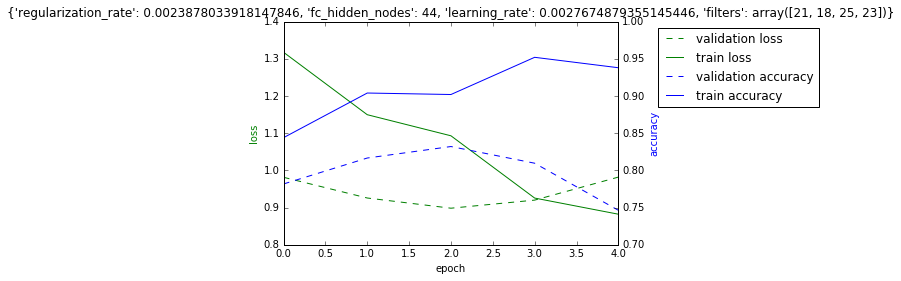

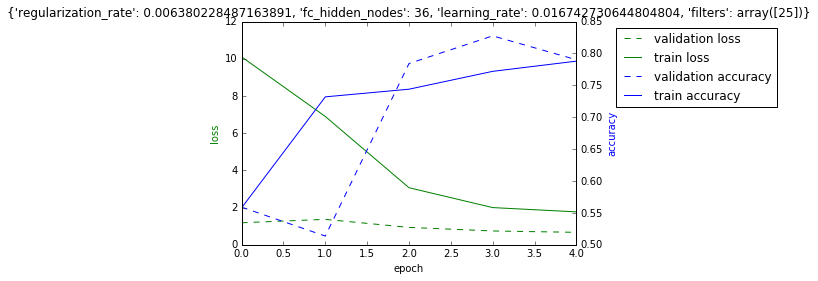

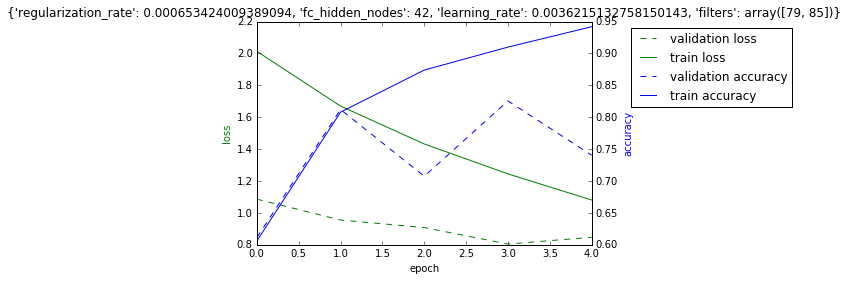

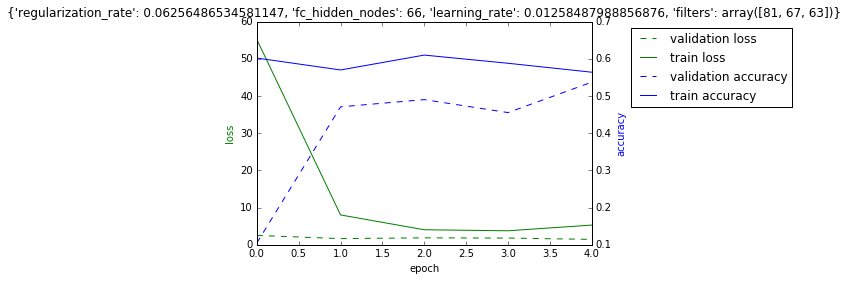

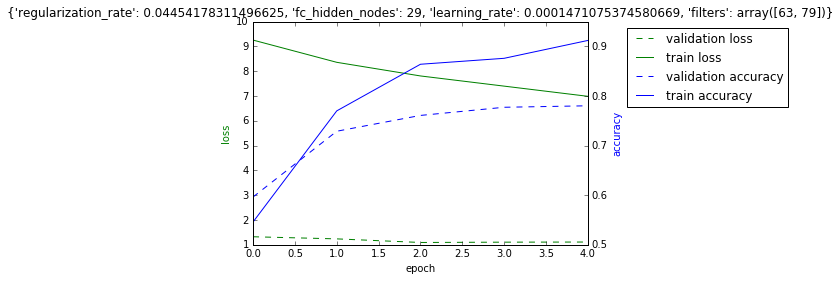

In [38]:
%%time
for i in range(len(models)):
    name = str(models[i][1])
    find_architecture.plotTrainingProcess(histories[i], name)

In [39]:
import pandas as pd
results = pd.DataFrame({'model':[str(params) for model, params, model_types in models],
                       'train_acc': [history.history['acc'][-1] for history in histories],
                       'train_loss': [history.history['loss'][-1] for history in histories],
                       'val_acc': [history.history['val_acc'][-1] for history in histories],
                       'val_loss': [history.history['val_loss'][-1] for history in histories]
                       })
results

,model,train_acc,train_loss,val_acc,val_loss
0,"{'regularization_rate': 0.0023878033918147846,...",0.938,0.882269,0.746388,0.981976
1,"{'regularization_rate': 0.006380228487163891, ...",0.788,1.770438,0.790234,0.670705
2,"{'regularization_rate': 0.000653424009389094, ...",0.942,1.080952,0.740409,0.847104
3,"{'regularization_rate': 0.06256486534581147, '...",0.564,5.295989,0.537120,1.456249
4,"{'regularization_rate': 0.04454178311496625, '...",0.912,6.987309,0.780269,1.111573


In [40]:
results.to_csv(datapath+'results.csv')

## Train the best model for real

In [41]:
best_model_index = np.argmax(val_accuracies)
#best_model_index = 3

In [42]:
best_model, best_params, best_model_types = models[best_model_index]
print(best_model_index, best_model_types, best_params)

1 CNN {'regularization_rate': 0.006380228487163891, 'fc_hidden_nodes': 36, 'learning_rate': 0.016742730644804804, 'filters': array([25])}


We make a copy of the model, to start training from fresh.

In [43]:
best_model_copy = modelgen.generate_CNN_model(X_train.shape, num_classes, best_params['filters'], best_params['fc_hidden_nodes'],
                       best_params['learning_rate'], best_params['regularization_rate'])

In [45]:
# We can set some backend options to avoid NaNs
from keras import backend as K
print(K.floatx())
print(K.epsilon())
#K.set_epsilon(1e-5)

float32
1e-07


We're going to train the model on the complete data set, and save the model after each epoch

In [46]:
nr_epochs = 10
datasize = X_train.shape[0]#1000
history = best_model_copy.fit(X_train[:datasize,:,:], y_train_binary[:datasize,:],
              nb_epoch=nr_epochs, validation_data=(X_val, y_val_binary), 
                              callbacks=[keras.callbacks.ModelCheckpoint(datapath+'weights.{epoch:02d}-{val_loss:.2f}.hdf5')])

Train on 12497 samples, validate on 2007 samples
Epoch 1/10
12497/12497 [==============================] - 65s - loss: 2.3049 - acc: 0.7991 - val_loss: 0.4237 - val_acc: 0.9038
Epoch 2/10
12497/12497 [==============================] - 68s - loss: 1.3440 - acc: 0.8248 - val_loss: 0.6792 - val_acc: 0.8186
Epoch 3/10
12497/12497 [==============================] - 71s - loss: 1.2870 - acc: 0.8268 - val_loss: 0.6196 - val_acc: 0.8266
Epoch 4/10
12497/12497 [==============================] - 73s - loss: 1.2022 - acc: 0.8343 - val_loss: 0.3767 - val_acc: 0.8615
Epoch 5/10
12497/12497 [==============================] - 125s - loss: 1.2249 - acc: 0.8327 - val_loss: 0.5709 - val_acc: 0.8161
Epoch 6/10
12497/12497 [==============================] - 101s - loss: 1.2085 - acc: 0.8303 - val_loss: 0.3711 - val_acc: 0.8734
Epoch 7/10
12497/12497 [==============================] - 109s - loss: 1.1394 - acc: 0.8320 - val_loss: 0.2996 - val_acc: 0.8909
Epoch 8/10
12497/12497 [============================

If we plot the training process, we see that the model is probably already overfitting in the first epoch. 

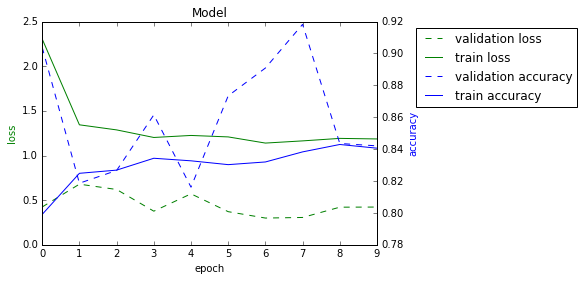

In [47]:
find_architecture.plotTrainingProcess(history)

In [76]:
#Load model from the  just before we get the NaNs
model_copy = keras.models.copy.copy(best_model_copy)
model_copy.load_weights(datapath+'weights.{epoch:02d}-{val_loss:.2f}.hdf5'.format(epoch=3, val_loss=0.22))
model_copy.compile(best_model_copy.optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model_copy = best_model_copy
model_copy.evaluate(X_train, y_train_binary)

## Inspect model predictions

In [ ]:
datasize = X_val.shape[0]
probs = best_model_copy.predict_proba(X_val[:datasize,:,:],batch_size=1)
probs

1990/2007 [============================>.] - ETA: 0s

In [79]:
len(best_model.layers)

10

In [82]:
best_model_copy.layers[0].get_weights()

[array([ 1.05805969,  1.08182418,  1.05226934,  1.11985362,  1.11457896,
         1.08258474,  1.0675174 ,  1.09842944,  1.04272151], dtype=float32),
 array([-0.01621632,  0.00915477,  0.03112106, -0.00480812, -0.04024399,
         0.02938126,  0.02135731,  0.02876085,  0.02071398], dtype=float32),
 array([-5.03031445,  4.6670599 ,  3.88478112,  9.46627522,  0.05378294,
        -2.32858896,  0.26191753,  7.91399288, -1.74101698], dtype=float32),
 array([ 6.4479332 ,  6.31256723,  4.06258011,  6.53865671,  8.00042725,
         3.90192032,  1.78485167,  4.96417904,  4.87879181], dtype=float32)]

In [83]:
from keras import backend as K

# with a Sequential model
get_dens_layer_output = K.function([best_model_copy.layers[0].input, K.learning_phase()],
                                  [best_model_copy.layers[0].output])
layer_output = get_dens_layer_output([X_val, 0])[0]
layer_output

array([[[  9.14543152e-01,  -5.22749007e-01,   1.20961297e+00, ...,
           1.27866900e+00,  -1.36577868e+00,   2.07329273e+00],
        [  8.51596296e-01,  -4.23463970e-01,   1.41696489e+00, ...,
           9.61874366e-01,  -1.32358003e+00,   2.09593701e+00],
        [  8.29028249e-01,  -3.18831891e-01,   1.48567891e+00, ...,
           6.45163417e-01,  -1.36463904e+00,   2.12711763e+00],
        ..., 
        [  8.33073676e-01,  -5.33392504e-02,   1.30498242e+00, ...,
           3.66124213e-01,  -1.23794603e+00,   2.32352901e+00],
        [  8.69708896e-01,  -4.08081971e-02,   1.27587688e+00, ...,
           3.05379510e-01,  -1.22057402e+00,   2.41411233e+00],
        [  8.45695853e-01,  -8.58338997e-02,   1.32538247e+00, ...,
           3.95880163e-01,  -1.22073758e+00,   2.40642452e+00]],

       [[  8.95305097e-01,  -1.51136845e-01,   1.34682620e+00, ...,
           2.57436574e-01,  -1.26235223e+00,   2.38910627e+00],
        [  8.70019019e-01,  -1.90006688e-01,   1.33645797e+0

In [26]:
best_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
batchnormalization_5 (BatchNormal(None, 512, 9)        18          batchnormalization_input_5[0][0] 
____________________________________________________________________________________________________
convolution1d_10 (Convolution1D) (None, 512, 98)       2744        batchnormalization_5[0][0]       
____________________________________________________________________________________________________
activation_18 (Activation)       (None, 512, 98)       0           convolution1d_10[0][0]           
____________________________________________________________________________________________________
convolution1d_11 (Convolution1D) (None, 512, 67)       19765       activation_18[0][0]              
___________________________________________________________________________________________

In [84]:
score_val = best_model_copy.evaluate(X_val, y_val_binary, verbose=True)
score_val

2007/2007 [==============================] - 19s    


[0.21868674527978088, 0.93622321873442949]

## Test on Testset

In [ ]:
score_test = best_model.evaluate(X_test, y_test_binary, verbose=False)
print('Score of best model: ' + str(score_test))